# Notebook to plot identity-conditioned noise correlations of example units.

This notebook requires noise correlation data cached in
`../../cache/figures/figure_2/noise_correlations_triangle`. This can be
downloaded from the OSF repo or can be generated by navigating to
`../../cache/figures/figure_2/` and running `$ python run_compute_triangle.py`.

This notebook saves the resulting plot in the current directory.

In [1]:
"""Imports."""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import AnchoredSizeLocator

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
"""Load data."""

_BASE_DATA_DIR = Path('../../cache/figures/figure_2/noise_correlations_triangle')

# Specify trio of units to plot
_SUBJECT = 'Perle'
_SESSION = '2022-05-31'
_CONDITIONS = ['0', '2']
_UNITS = [137, 138, 139, 148]

# Load data for this session
condition_dir = _BASE_DATA_DIR / _SUBJECT / _SESSION
units = np.load(condition_dir / 'units.npy')
conditions_raw = np.load(condition_dir / 'conditions.npy')
firing_rate_mat = np.load(condition_dir / 'firing_rate_mat.npy')\

# Make conditions position
def _cond_to_pos(cond):
    cond_pos = [x for x in cond if x.isdigit()]
    if len(cond_pos) == 2:
        cond_pos.insert(1, '_')
    return ''.join(cond_pos)
def _cond_to_id(cond):
    cond_pos = [x for x in cond if x in ["a", "b", "c"]]
    if len(cond_pos) == 2:
        cond_pos.insert(1, '_')
    return ''.join(cond_pos)
conditions = np.array([_cond_to_pos(cond) for cond in conditions_raw])
conditions_id = np.array([_cond_to_id(cond) for cond in conditions_raw])

# Get unit indices
unit_indices = [np.where(units == unit)[0][0] for unit in _UNITS]

# Get unit firing rates for each single condition
fr_vecs = {}
for cond in _CONDITIONS:
    trial_inds = conditions == cond
    for unit_ind in unit_indices:
        fr = firing_rate_mat[unit_ind, trial_inds]
        fr = fr[~np.isnan(fr)]
        fr_vecs[(unit_ind, cond)] = fr
        
# Get unit firing rates for combonation condition
trial_inds_cond_combo = conditions == '_'.join(_CONDITIONS)
unit_ind_pairs = [
    (unit_indices[i], unit_indices[j])
    for i, j in [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
]
for unit_ind_pair in unit_ind_pairs:
    fr_unit_ind_0 = firing_rate_mat[unit_ind_pair[0], trial_inds_cond_combo]
    fr_unit_ind_1 = firing_rate_mat[unit_ind_pair[1], trial_inds_cond_combo]
    keep_inds = ~np.isnan(fr_unit_ind_0) & ~np.isnan(fr_unit_ind_1)
    fr_unit_ind_0 = fr_unit_ind_0[keep_inds]
    fr_unit_ind_1 = fr_unit_ind_1[keep_inds]
    cond_ids = conditions_id[trial_inds_cond_combo][keep_inds]
    fr_vecs[unit_ind_pair] = (fr_unit_ind_0, fr_unit_ind_1, cond_ids)

/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_20891/2735584611.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


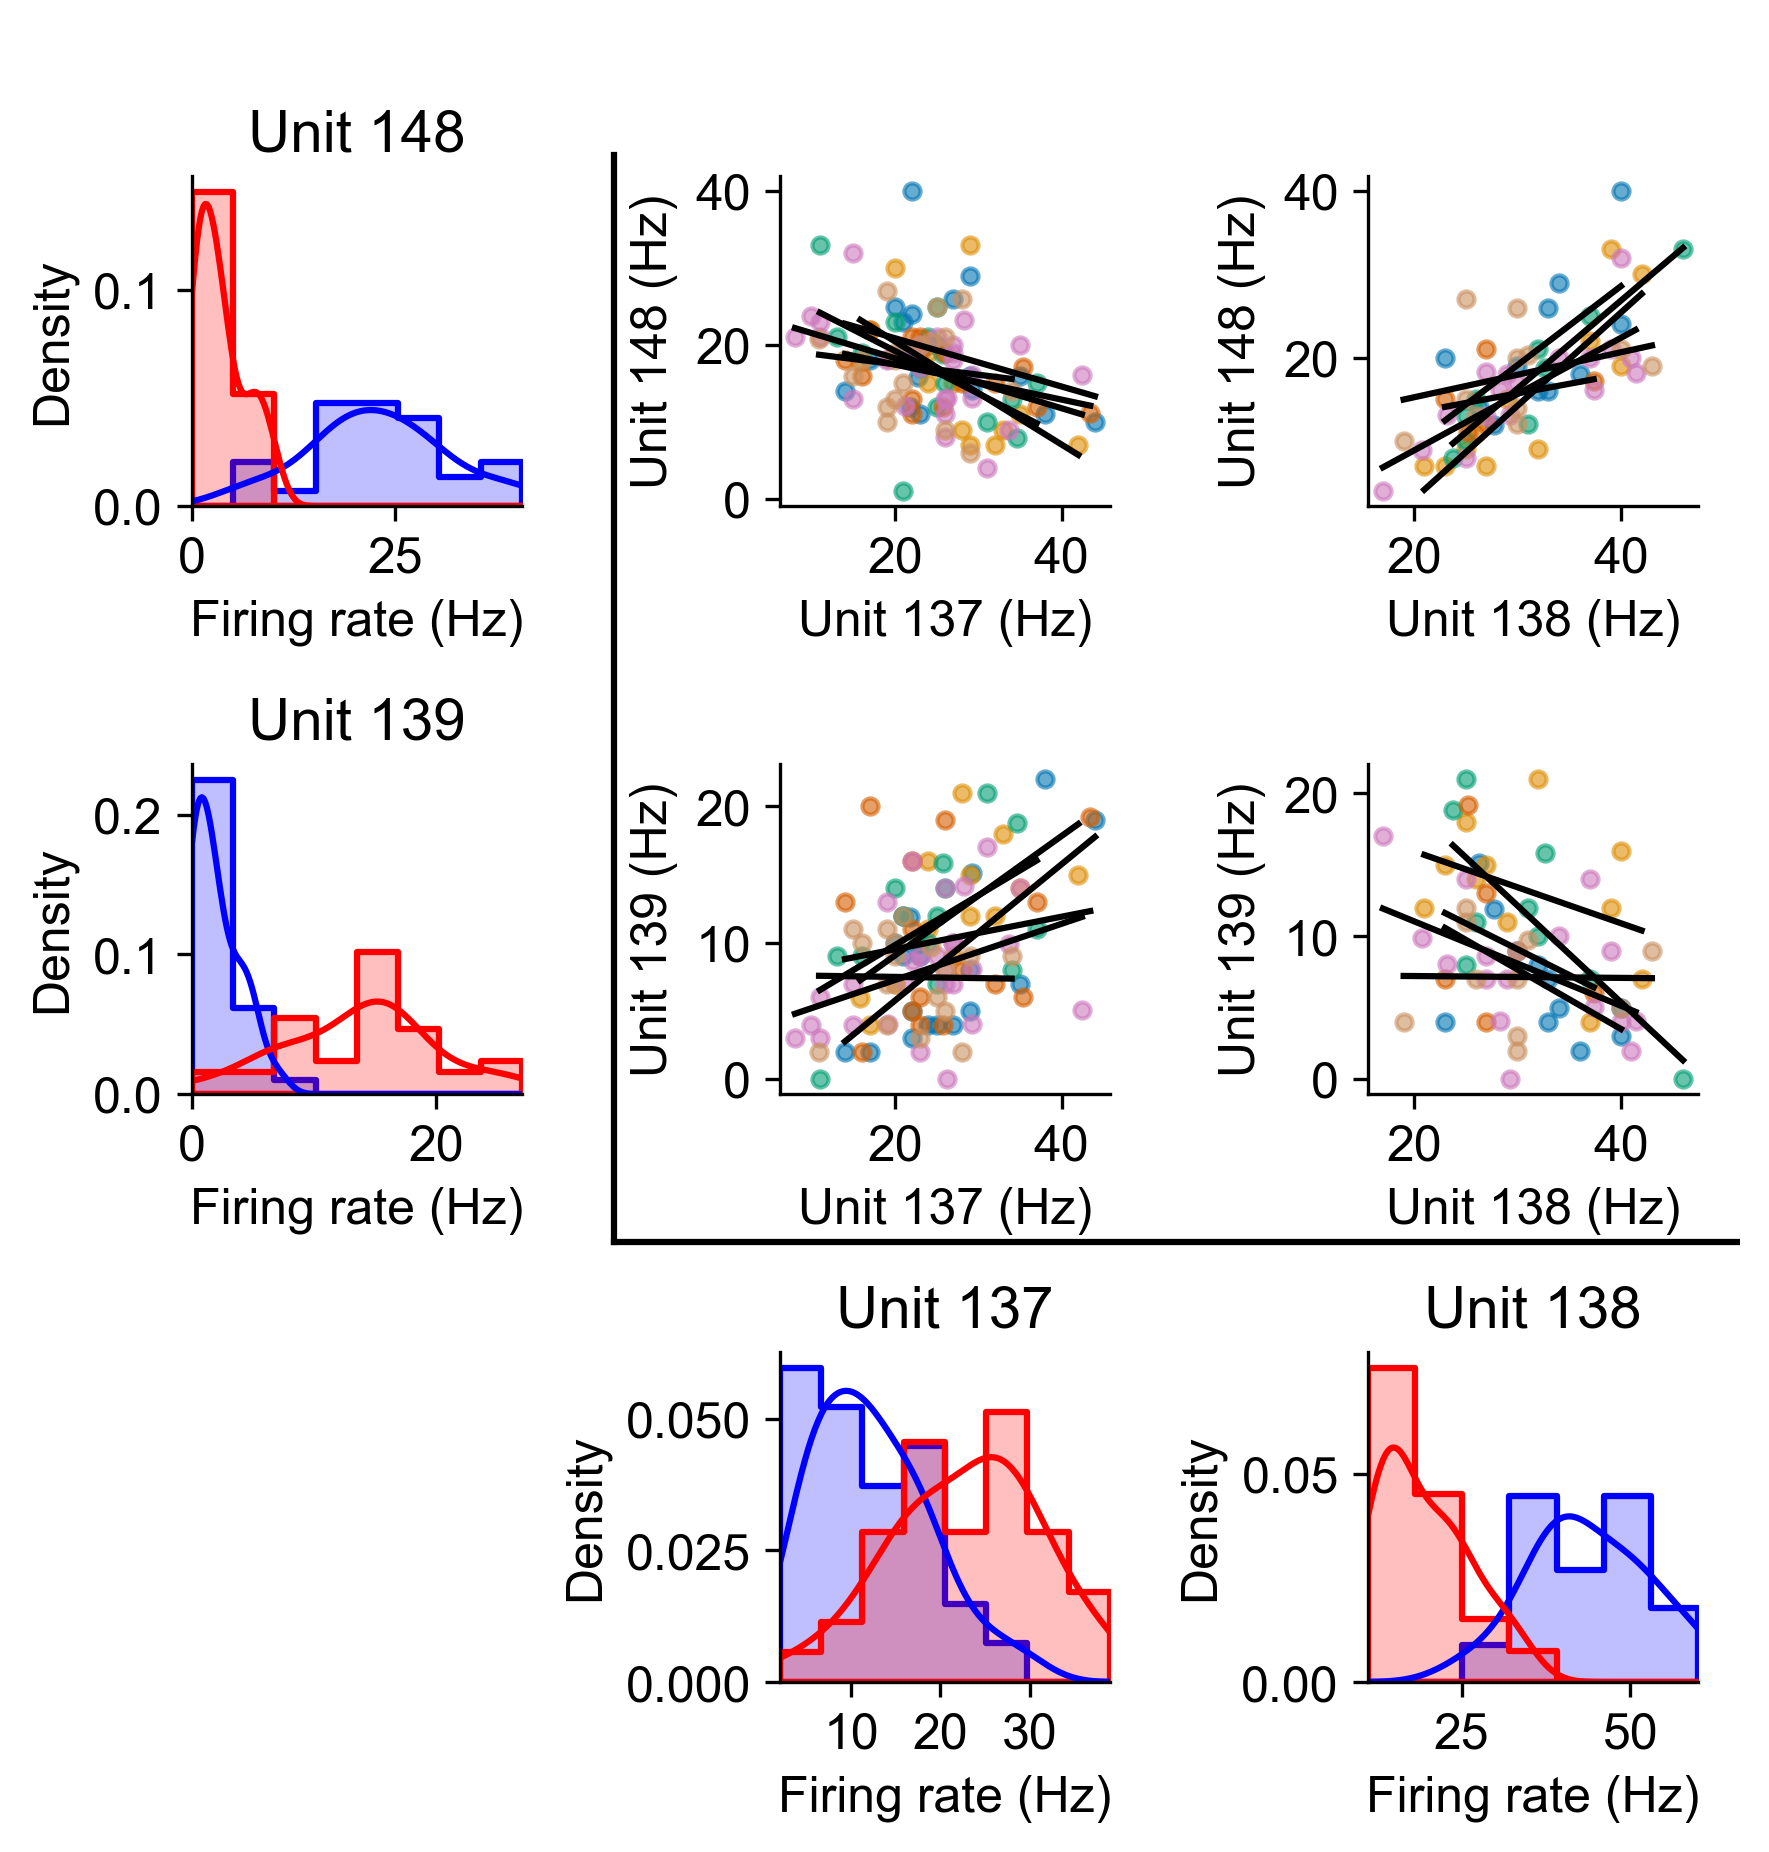

In [3]:
"""Make plot."""

colors_palette = sns.color_palette("colorblind", 6)
PALETTE = {
    (0,): (1, 0, 0),
    (1,): (0, 1, 0),
    (2,): (0, 0, 1),
    (0, 1): (0.7, 0.7, 0),
    (0, 2): (0.7, 0, 0.7),
    (1, 2): (0, 0.7, 0.7),
    (0, 1, 2): (0.5, 0.5, 0.5),
    "a_b": colors_palette[0],
    "a_c": colors_palette[1],
    "b_a": colors_palette[2],
    "b_c": colors_palette[3],
    "c_a": colors_palette[4],
    "c_b": colors_palette[5],
}

fig_height = 7.5
fig_width = 8
axis_sidelength = 1.1
v_sep = 0.86
h_sep = 0.86
fig = plt.figure(figsize=(fig_width, fig_height))
axes = []
h_levels = [-h_sep - axis_sidelength, 0, h_sep + axis_sidelength]
v_levels = [v_sep + axis_sidelength, 0, -v_sep - axis_sidelength]

def _plot(ax_location, spec):
    ax_location = [
        0.5 * fig_width + ax_location[0],
        0.5 * fig_height + ax_location[1] - 0.5 * axis_sidelength,
        axis_sidelength,
        axis_sidelength,
    ]
    ax = fig.add_axes(ax_location)
    sns.despine(ax=ax)
    axes_locator = AnchoredSizeLocator(
        ax_location, "100%", "100%", loc="center",
        bbox_transform=fig.dpi_scale_trans, borderpad=0,
    )
    ax.set_axes_locator(axes_locator)
    axes.append(ax)
    
    if len(spec) == 1:
        unit = unit_indices[spec[0]]
        unit_id = _UNITS[spec[0]]
        min_fr = min([fr_vecs[(unit, cond_i)].min() for cond_i in _CONDITIONS])
        max_fr = max([fr_vecs[(unit, cond_i)].max() for cond_i in _CONDITIONS])
        
        # make dataframe
        df_tmp = {
            'unit': [],
            'condition': [],
            'firing_rate': [],
        }
        for cond_i in [_CONDITIONS[0], _CONDITIONS[1]]:
            df_tmp['unit'] += [unit_id] * len(fr_vecs[(unit, cond_i)])
            df_tmp['condition'] += [cond_i] * len(fr_vecs[(unit, cond_i)])
            df_tmp['firing_rate'] += fr_vecs[(unit, cond_i)].tolist()
        df_tmp = pd.DataFrame(df_tmp)
        sns.histplot(
            data=df_tmp, x='firing_rate', hue='condition', ax=ax,
            palette=[PALETTE[(int(cond_i),)] for cond_i in _CONDITIONS],
            common_norm=False, element='step', stat='density',
            kde=True, linewidth=1.5,
            legend=False,
        )
        ax.set_title(f'Unit {unit_id}')
        ax.set_xlabel('Firing rate (Hz)')
        ax.set_xlim(min_fr, max_fr)
    else:
        unit_pair = tuple([unit_indices[i] for i in spec])
        unit_ids = [_UNITS[i] for i in spec]
        ids = fr_vecs[unit_pair][2]
        x_vals = fr_vecs[unit_pair][0]
        y_vals = fr_vecs[unit_pair][1]
        
        for id_sample in np.unique(ids):
            indices = ids == id_sample
            sns.regplot(
                x=x_vals[indices],
                y=y_vals[indices],
                ax=ax,
                scatter=True,
                scatter_kws={
                    'color': PALETTE[id_sample],
                    's': 15,
                    'alpha': 0.6,
                },
                line_kws={'color': 'k', 'linewidth': 1.5},
                ci=None,
            )
        ax.set_xlabel(f'Unit {unit_ids[0]} (Hz)')
        ax.set_ylabel(f'Unit {unit_ids[1]} (Hz)')
        corr_coef = np.corrcoef(fr_vecs[unit_pair][0], fr_vecs[unit_pair][1])[0, 1]
        num_points = len(fr_vecs[unit_pair][0])
        # ax.set_title(f'R={corr_coef:.2f}, N={num_points}', fontsize=12)

# make top row
for i, spec in enumerate([(3,), (0, 3), (1, 3)]):
    _plot((h_levels[i], v_levels[0]), spec)

# make middle row
for i, spec in enumerate([(2,), (0, 2), (1, 2)]):
    _plot((h_levels[i], v_levels[1]), spec)

# make bottom row
for i, spec in enumerate([(0,), (1,)]):
    _plot((h_levels[i + 1], v_levels[2]), spec)

# Draw vertical line in figure at hlevels[1]
ax_meta = plt.axes([0.2, 0.2, 0.7, 0.7], facecolor=(1,1,1,0))
ax_meta.axis('off')
from matplotlib.lines import Line2D
line = Line2D([0.33, 0.33], [0.23, 0.92], color='k')
ax_meta.add_line(line)
line = Line2D([0.33, 1.2], [0.23, 0.23], color='k')
ax_meta.add_line(line)

# Save figure
fig.tight_layout()
fig.savefig('example_units_conditional.pdf', bbox_inches='tight', pad_inches=0.01)